In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
# import keras_tuner
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from tensorflow.keras.applications.resnet50 import ResNet50


#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2024-04-13 16:34:07.648905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 16:34:09.145129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


In [2]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 32
seeds = 41
im_shape = (250,250)

In [4]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


## ResNet50

In [5]:
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(250,250,3))

for layer in resnet50.layers:
    layer.trainable=False

resnet_model = Sequential()
resnet_model.add(resnet50)
resnet_model.add(BatchNormalization())
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dropout(0.25))
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dropout(0.25))
resnet_model.add(Dense(6, activation='softmax'))
resnet_model.summary()

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-04-13 16:34:23.905900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 16:34:23.960966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 16:34:23.961284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization (Batch  (None, 8, 8, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                         

In [6]:
import time
# Record the start time of training
start_time = time.time()

In [7]:
# Train the model
epochs = 10

#Training
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='resnet50_model_0.25dropout.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]


#Training
resnet_history = resnet_model.fit(
        train_generator,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1)

Epoch 1/10


2024-04-13 16:34:53.327375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-13 16:34:55.497133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-13 16:34:56.928926: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x22e114a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 16:34:56.928979: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-13 16:34:56.974946: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 16:34:57.295094: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

53/53 [==============================] - ETA: 0s - loss: 1.5097 - accuracy: 0.3869
Epoch 1: val_loss improved from inf to 3.33116, saving model to resnet50_model_0.25dropout.h5
53/53 [==============================] - 58s 914ms/step - loss: 1.5097 - accuracy: 0.3869 - val_loss: 3.3312 - val_accuracy: 0.1667
Epoch 2/10
53/53 [==============================] - ETA: 0s - loss: 1.2930 - accuracy: 0.4946
Epoch 2: val_loss improved from 3.33116 to 2.42142, saving model to resnet50_model_0.25dropout.h5
53/53 [==============================] - 47s 892ms/step - loss: 1.2930 - accuracy: 0.4946 - val_loss: 2.4214 - val_accuracy: 0.1881
Epoch 3/10
53/53 [==============================] - ETA: 0s - loss: 1.1643 - accuracy: 0.5637
Epoch 3: val_loss improved from 2.42142 to 2.05253, saving model to resnet50_model_0.25dropout.h5
53/53 [==============================] - 50s 946ms/step - loss: 1.1643 - accuracy: 0.5637 - val_loss: 2.0525 - val_accuracy: 0.2643
Epoch 4/10
53/53 [=========================

In [8]:
# Record the training end time
end_time = time.time()

In [9]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 582.3094856739044 seconds


In [10]:
pd.DataFrame(resnet_history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.509687,0.386905,3.331165,0.166667
1,1.293037,0.494643,2.421422,0.188095
2,1.164297,0.563690,2.052529,0.264286
3,1.162210,0.553571,1.806308,0.347619
4,1.048835,0.600000,1.577260,0.407143
5,1.019092,0.607738,1.235138,0.528571
6,1.023347,0.600000,1.205877,0.585714
7,1.013601,0.602381,1.171609,0.571429
8,0.987679,0.620238,1.060666,0.602381
9,0.945067,0.646429,1.126397,0.588095


In [11]:
import joblib

joblib.dump(resnet_history.history,'history_ResNet50_0.25dropout.pkl')
resnet_history = joblib.load('history_ResNet50_0.25dropout.pkl')

In [12]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

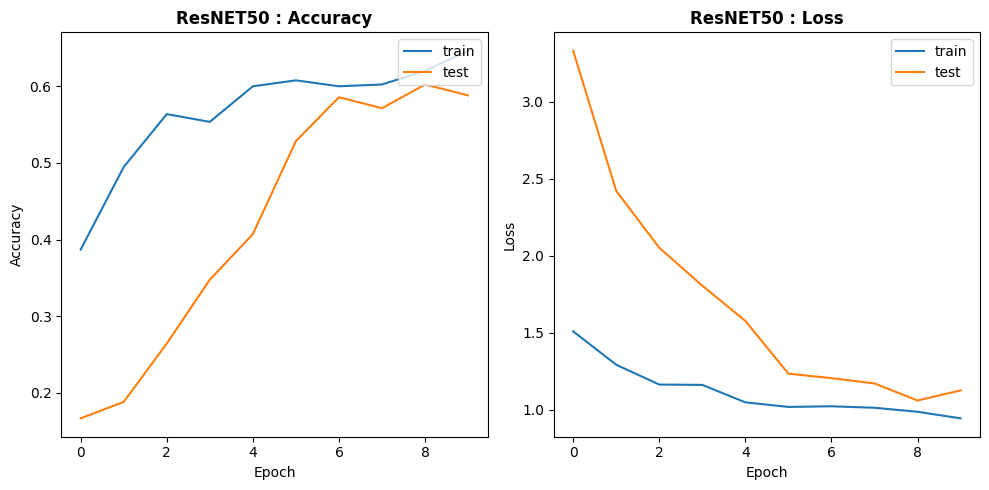

In [13]:
plot_performance(model_name='ResNET50',
                acc=resnet_history['accuracy'],
                 val_acc=resnet_history['val_accuracy'],
                 loss=resnet_history['loss'], 
                 val_loss=resnet_history['val_loss'])

In [14]:
# Load the best saved model
from keras.models import load_model

model_1 = load_model('resnet50_model_0.25dropout.h5')
score = model_1.evaluate(validation_generator)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model_1.evaluate(test_generator)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

14/14 [==============================] - 11s 660ms/step - loss: 1.1464 - accuracy: 0.5952

Val loss: 1.1463795900344849
Val accuracy: 0.5952380895614624
17/17 [==============================] - 14s 825ms/step - loss: 1.0071 - accuracy: 0.6364

Test loss: 1.0071086883544922
Test accuracy: 0.6363636255264282


In [15]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

17/17 [==============================] - 13s 692ms/step
Classification Report
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.69      0.78      0.73        88
           brown_spot       0.53      0.27      0.36        88
              healthy       0.60      0.80      0.69        88
           leaf_blast       0.46      0.42      0.44        88
           leaf_scald       0.73      0.68      0.71        88
    narrow_brown_spot       0.62      0.74      0.67        88

             accuracy                           0.62       528
            macro avg       0.61      0.62      0.60       528
         weighted avg       0.61      0.62      0.60       528



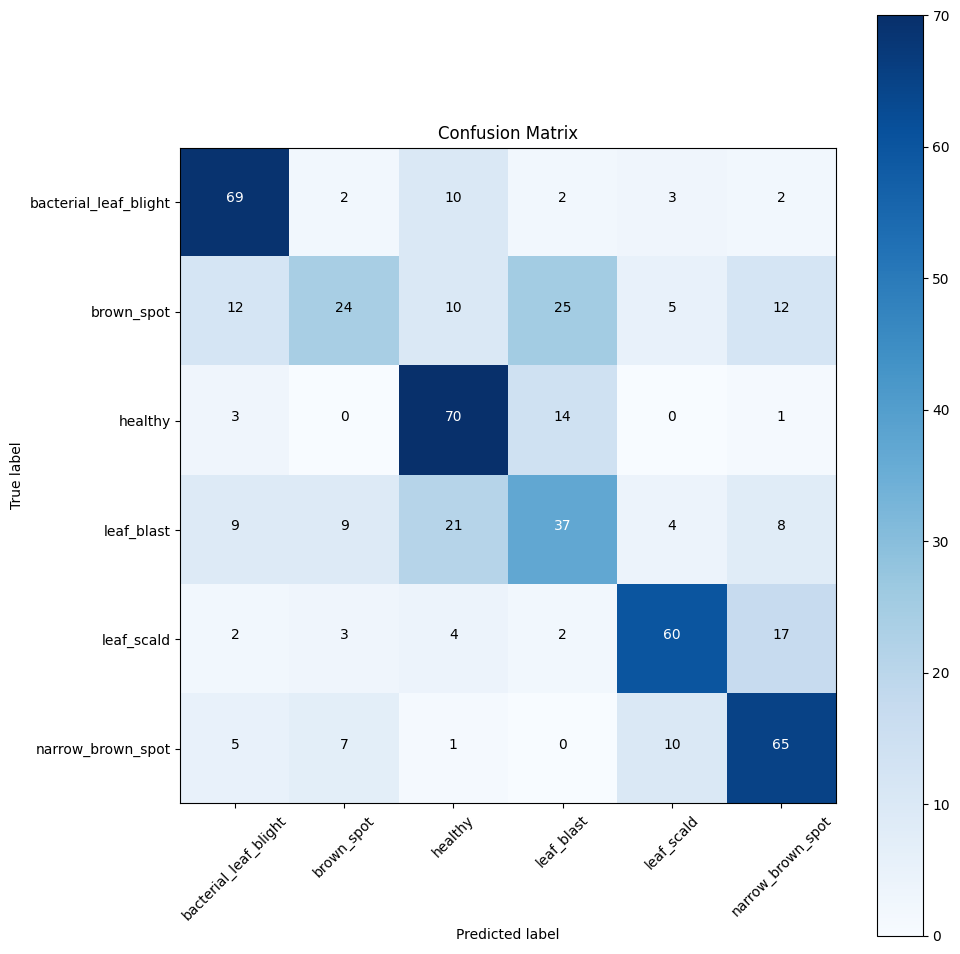

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model_1.predict(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=1))

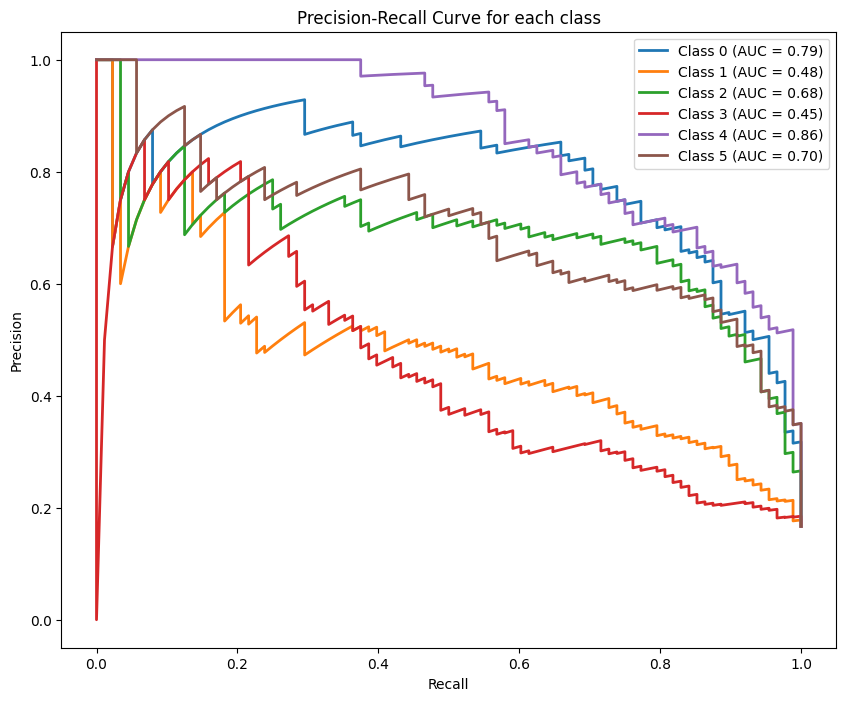

In [17]:
# Precision-Recall Curve for each class
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])
    
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend(loc="best")
plt.show()

In [18]:
#Generate predictions for the test dataset
y_pred = model_1.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

17/17 [==============================] - 12s 687ms/step


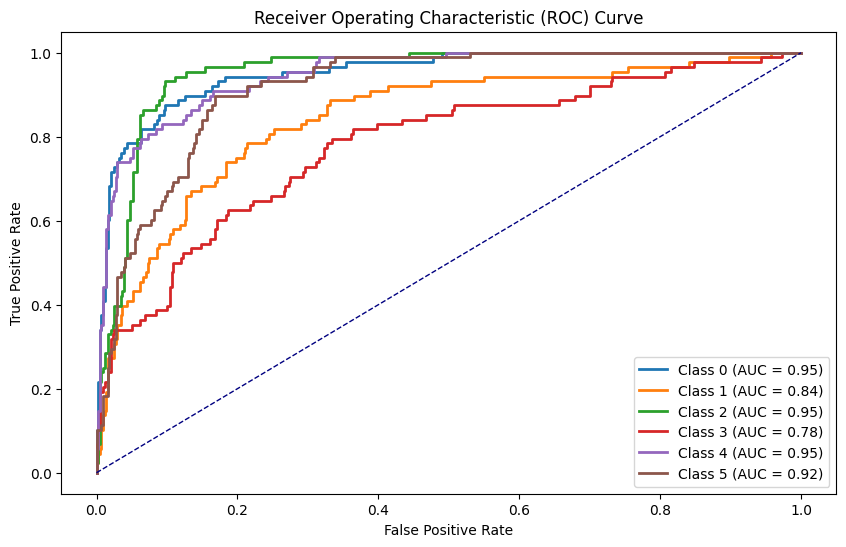

In [19]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc


#Get the true labels from thee test generator
# y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize arrays to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [20]:
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Output Sensitivity and Specificity for each category
for idx, (sen, spec) in enumerate(zip(sensitivity_list, specificity_list)):
    print(f"Class {idx} - Sensitivity: {sen}, Specificity: {spec}")

Class 0 - Sensitivity: 0.7840909090900181, Specificity: 0.9295454545452433
Class 1 - Sensitivity: 0.2727272727269628, Specificity: 0.9522727272725109
Class 2 - Sensitivity: 0.7954545454536415, Specificity: 0.895454545454342
Class 3 - Sensitivity: 0.42045454545406763, Specificity: 0.9022727272725223
Class 4 - Sensitivity: 0.681818181817407, Specificity: 0.9499999999997841
Class 5 - Sensitivity: 0.7386363636355242, Specificity: 0.9090909090907026


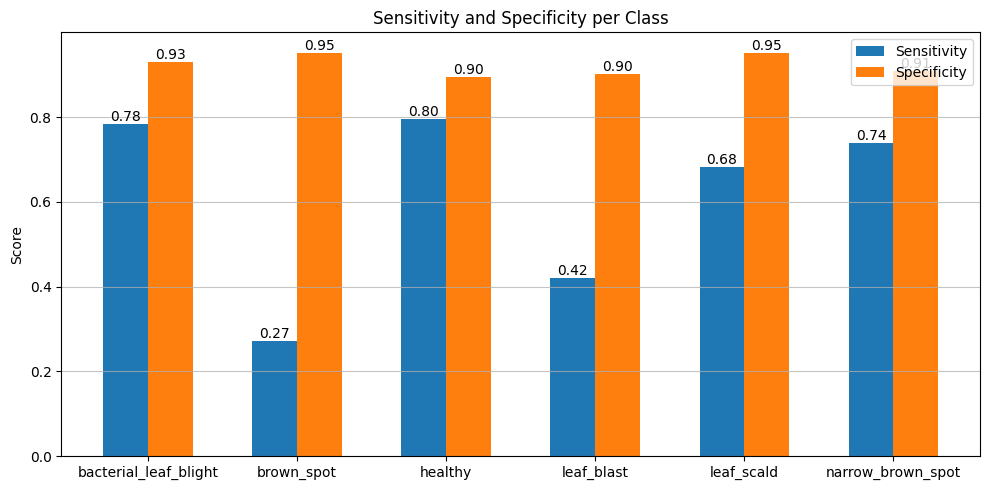

In [22]:
# 设置图形的宽度和位置  
N = len(sensitivity_list)  
ind = np.arange(N)  
width = 0.3  # 每个条形图的宽度  
  
# 绘制灵敏度的条形图  
plt.figure(figsize=(10, 5))  
sensitivity_bars = plt.bar(ind, sensitivity_list, width, label='Sensitivity')  
  
# 绘制特异度的条形图（注意：位置需要偏移以避免重叠）  
specificity_bars = plt.bar(ind + width, specificity_list, width, label='Specificity')  
  
# 设置x轴的刻度标签（假设您有一个类标签列表classes）  
classes = ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']  
plt.xticks(ind + width / 2, classes)  
  
# 设置x轴的标签为类别索引（如果没有具体的类标签列表）  
# plt.xticks(ind + width / 2, range(1, N + 1))  
  
# 设置y轴的标签  
plt.ylabel('Score')  
  
# 添加标题  
plt.title('Sensitivity and Specificity per Class')  
  
# 添加图例  
plt.legend()  
  
# 显示网格线  
plt.grid(axis='y', alpha=0.75)  
  
# 调整x轴和y轴的边距，以确保条形图完全可见  
plt.tight_layout()  
  
# 为每个条形添加数字标签  
def add_value_labels(bars, values):  
    for bar, value in zip(bars, values):  
        height = bar.get_height()  
        plt.text(bar.get_x() + bar.get_width() / 2, height,  
                 '{:.2f}'.format(value),  
                 ha='center', va='bottom')  
  
add_value_labels(sensitivity_bars, sensitivity_list)  
add_value_labels(specificity_bars, specificity_list)  
  
# 显示图形  
plt.show()

In [23]:
# Evaluate the performance of the model
evaluate = model_1.evaluate(
    test_generator, 
    steps = test_generator.n // BATCH_SIZE, 
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

16/16 [==============================] - 13s 779ms/step - loss: 0.9792 - accuracy: 0.6348
Accuracy Test : 0.634765625
